In [98]:

import starsim as ss
import tbsim as mtb
import numpy as np
import pandas as pd
import sciris as sc
import tbsim.config as cfg
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import os 


In [99]:

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


In [100]:

debug = True
default_n_rand_seeds = [250, 1][debug]


In [101]:

def compute_rel_LS_prog(macro, micro):
    assert len(macro) == len(micro), 'Length of macro and micro must match.'
    ret = np.ones_like(macro)
    ret[(macro == mtb.MacroNutrients.STANDARD_OR_ABOVE)         & (micro == mtb.MicroNutrients.DEFICIENT)] = 1.0
    ret[(macro == mtb.MacroNutrients.SLIGHTLY_BELOW_STANDARD)   & (micro == mtb.MicroNutrients.DEFICIENT)] = 10.0
    ret[(macro == mtb.MacroNutrients.MARGINAL)                  & (micro == mtb.MicroNutrients.DEFICIENT)] = 20.0
    ret[(macro == mtb.MacroNutrients.UNSATISFACTORY)            & (micro == mtb.MicroNutrients.DEFICIENT)] = 20.0
    return ret


In [102]:

def run_harlem(rand_seed=0):

    np.random.seed(rand_seed)

    # ------------------- Harlem -------------------
    harlem = mtb.Harlem()

    # ------------------- People -------------------
    pop = harlem.people()

    # ------------------- Networks -------------------

    # Network parameters
    randnet_pars = dict(
        n_contacts=ss.poisson(lam=5),
        dur = 0, # End after one timestep
    )
    randnet = ss.RandomNet(randnet_pars)    # Initialize a random network
       
    harlemnet = harlem.net()                # Harlem network   
    matnet = ss.MaternalNet()               # To track newborn --> household
    nets = [harlemnet, randnet, matnet]     # Combine all networks

    # ------------------- TB disease -------------------
    # Disease parameters
    tb_pars = dict(
        beta = dict(harlem=0.03, random=0.003, maternal=0.0),
        init_prev = 0, # Infections seeded by Harlem class
        rate_LS_to_presym = 3e-5 / 2, # Slow down LS-->Presym as this is now the rate for healthy individuals

        # Relative transmissibility by TB state
        rel_trans_smpos     = 1.0,
        rel_trans_smneg     = 0.3,
        rel_trans_exptb     = 0.05,
        rel_trans_presymp   = 0.10,
    )
    tb = mtb.TB(tb_pars)

    # ------------------- Nutrition -------------------
    malnut_pars = dict()
    malnut = mtb.Nutrition(malnut_pars)

    # Add demographics
    dems = [
        ss.Pregnancy(pars=dict(fertility_rate=45)), # Per 1,000 women
        ss.Deaths(pars=dict(death_rate=10)), # Per 1,000 people (background deaths, excluding TB-cause)
    ]

    # ------------------- Connector -------------------
    cn_pars = dict(
        rel_LS_prog_func=compute_rel_LS_prog,
        relsus_microdeficient=5 # Increased susceptibilty of those with micronutrient deficiency (could make more complex function like LS_prog)
    )
    cn = mtb.TB_Nutrition_Connector(cn_pars)

    # ------------------- Interventions -------------------
    
    # Define vitamin supplementation intervention
    vs = mtb.VitaminSupplementation(year=[1942, 1943], 
                                    rate=[10.0, 3.0]) # Need coverage, V1 vs V2
    
    # Define macro nutrient interventions
    m = mtb.MacroNutrients
    lsff0 = mtb.LargeScaleFoodFortification(year=[1942, 1944], 
                                            rate=[1.25, 0], 
                                            from_state=m.UNSATISFACTORY, 
                                            to_state=m.MARGINAL)
    
    lsff1 = mtb.LargeScaleFoodFortification(year=[1942, 1944], 
                                            rate=[1.75, 0], 
                                            from_state=m.MARGINAL, 
                                            to_state=m.SLIGHTLY_BELOW_STANDARD)
    
    lsff2 = mtb.LargeScaleFoodFortification(year=[1942, 1944], 
                                            rate=[1.75, 0], 
                                            from_state=m.SLIGHTLY_BELOW_STANDARD, 
                                            to_state=m.STANDARD_OR_ABOVE)
    
    intvs = [vs, lsff0, lsff1, lsff2]

    # ------------------- Analyzer -------------------
    az = mtb.HarlemAnalyzer()

    # -------------------- Simulation -------------------
    # define simulation parameters
    sim_pars = dict(
        dt = 7/365,
        start = 1935, # Start early to burn-in
        #start = 1942,
        end = 1947,
        rand_seed = rand_seed,
        )
    
    # initialize the simulation
    sim = ss.Sim(people=pop, 
                 networks=nets, 
                 diseases=[tb, malnut], 
                 pars=sim_pars, 
                 demographics=dems, 
                 connectors=cn, 
                 interventions=intvs, 
                 analyzers=az)
    
    sim.pars.verbose = sim.pars.dt / 5 # Print status every 5 years instead of every 10 steps

    sim.initialize()

    harlem.set_states(sim)
    seed_uids = harlem.choose_seed_infections(sim, p_hh=0.835) #83% or 84%
    tb.set_prognoses(sim, seed_uids)

    sim.run() # Actually run the sim

    df = sim.analyzers['harlemanalyzer'].df
    df['rand_seed'] = rand_seed

    print(f'Finishing sim with rand_seed={rand_seed} ')

    return df



In [103]:

def run_sims(n_seeds=default_n_rand_seeds):
    results = []
    cfgs = []
    for rs in range(n_seeds):
        cfgs.append({'rand_seed':rs})
    T = sc.tic()
    results = []
    cfgs = []
    for rs in range(n_seeds):
        cfgs.append({'rand_seed': rs})
        results.append(run_harlem(rs))

    print(f'That took: {sc.toc(T, output=True):.1f}s')

    df = pd.concat(results)
    df.to_csv(os.path.join(cfg.RESULTS_DIRECTORY, f"result_{cfg.FILE_POSTFIX}.csv"))

    return df


In [104]:

def plot(df):
    first_year = int(df['year'].iloc[0])
    assert df['year'].iloc[0] == first_year
    
    df['date'] = pd.to_datetime(365 * (df['year']-first_year), unit='D', origin=dt.datetime(year=first_year, month=1, day=1))

    d = pd.melt(df.drop(['rand_seed', 'year'], axis=1), id_vars=['date', 'arm'], var_name='channel', value_name='Value')
    g = sns.relplot(data=d, kind='line', x='date', hue='arm', col='channel', y='Value', palette='Set2',
        facet_kws={'sharey':False}, col_wrap=3, lw=2, errorbar='sd')

    g.set_titles(col_template='{col_name}', row_template='{row_name}')
    g.set_xlabels('Date')
    
    for ax in g.axes.flat:
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
    sc.savefig(f"result_{cfg.FILE_POSTFIX}.png", folder=cfg.RESULTS_DIRECTORY)
    plt.show()
    plt.close(g.figure)
    return

# plot(df)

Initializing sim with 804 agents


c:\git\newstarsim\starsim\disease.py:58: RuntimeWarning: 
Beta not supplied for disease "nutrition"; defaulting to 1
  ss.warn(msg)


  Running 1935.0 ( 0/625) (0.00 s)  ———————————————————— 0%
  Running 1940.0 (260/625) (2.77 s)  ••••••••———————————— 42%


c:\git\newstarsim\starsim\states.py:304: RuntimeWarning: invalid value encountered in log
  out = args[0](*args[2:], **kwargs)


  Running 1945.0 (520/625) (5.66 s)  ••••••••••••••••———— 83%
Finishing sim with rand_seed=0 
That took: 7.3s


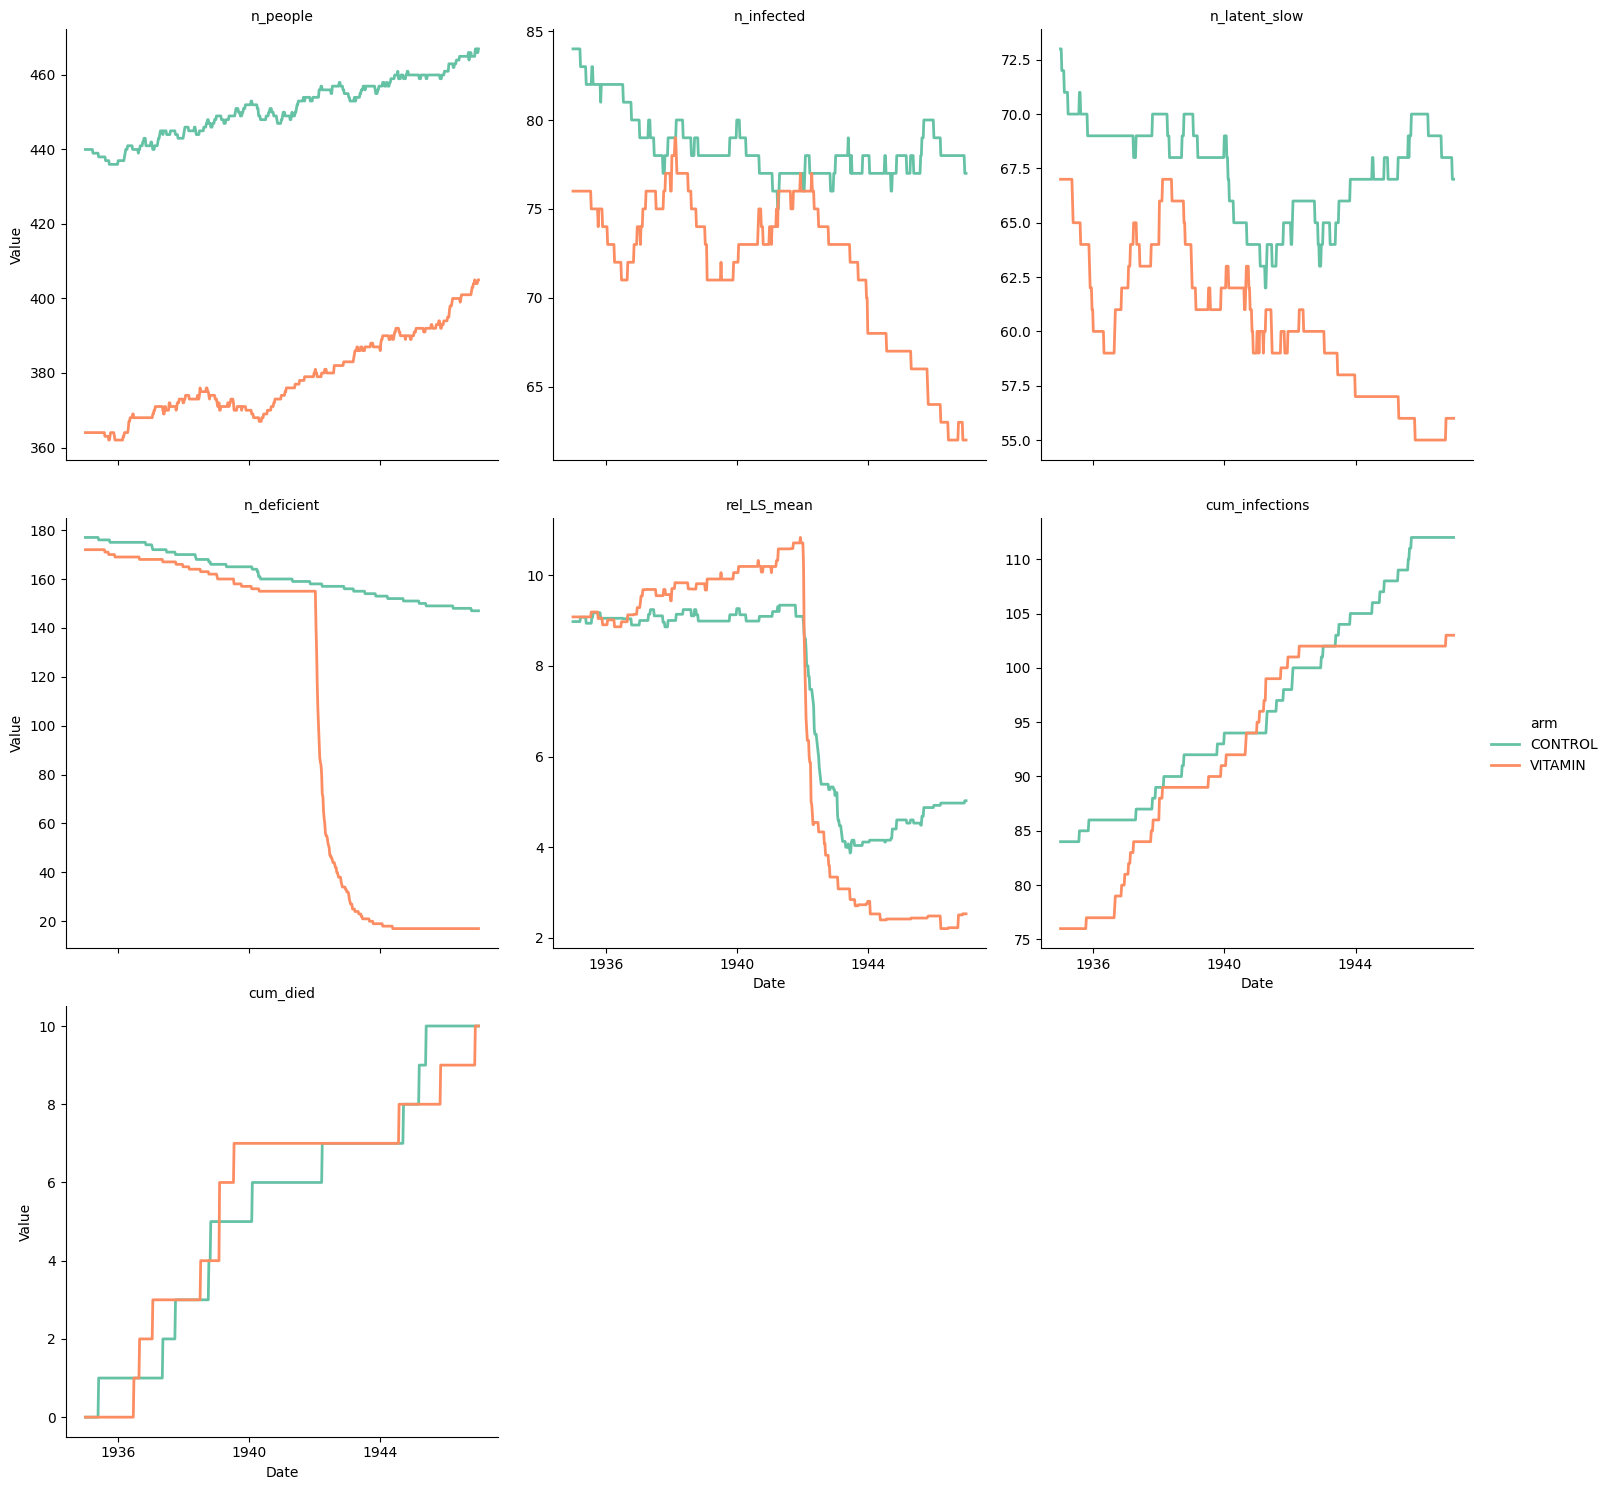

Results directory c:\git\tbsim\tests\e2e\figs\TB
This run: 04-26_16-45-04
Done


In [105]:
df = run_sims()
plot(df)
print(f"Results directory {cfg.RESULTS_DIRECTORY}\nThis run: {cfg.FILE_POSTFIX}")
print('Done')
